In [ ]:
"""
- A simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat

""" 

In [4]:
"""Some of these Codes are part of the deeplearning.ai specialization course """

import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from data_load import load_dataset


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [8]:
print(train_set_x_orig.shape)

(209, 64, 64, 3)


y = [1], it's a 'cat' picture.


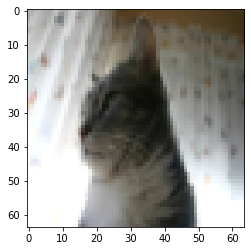

In [28]:
# Example of a picture
index = 106

plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [10]:
print(np.min(train_set_x_orig)) 
print(np.max(train_set_x_orig))

0
255


In [11]:
# Comfirming the shapes and dimensions
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

In [12]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [13]:
# Reshape the training and test data sets 
# so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px  ∗ num_px ∗ 3, 1).
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [14]:
train_set_x_flatten[0:10, 1]

array([196, 192, 190, 193, 186, 182, 188, 179, 174, 213], dtype=uint8)

In [15]:
#standardize our dataset.
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

#### Building the parts of our algorithm : helper functions

In [16]:
# Implementing a sigmoid function 

def sigmoid(z):
    s = 1.0/(1.0 + np.exp(-z))
    return s

In [17]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    w = np.zeros([dim, 1])
    b = 0.0
    return w, b

In [29]:
# forward and back propagate

def propagate(w, b, X, Y):
  
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    
    dw = np.dot(X,(np.subtract(A,Y).T))/m
    db = np.sum(A-Y)/m

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [30]:
# optimize, update the parameters using gradient descent

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):

    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
   
        grads,cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w -(learning_rate * dw)
        b = b -(learning_rate * db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [31]:
#  predict

def predict(w, b, X):

    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]  
        if A[0, i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    
    return Y_prediction

#### Merge all functions into a model

In [33]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
   
    # initialize parameters with zeros 
    w , b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent 
    params , grads , costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    
    # YOUR CODE ENDS HERE

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [36]:
# to train your model.
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
